# Application with Pharmacokinetic information

Make some plots that show an application of this type of modeling.  Two chemicals Tamoxifen (CASN 10540-29-1) and Fluvestrant (CASN 129453-61-8).  They are both cancer therapies for breast cancer and by targeting estrogen receptor antagonism and aromatase inhibition.  Tamoxifen is a liver toxicant where fluvestrant only mildly elevates liver toxicity.  They both have different concentration at steady states according to HTTK.

These HTTK values might differ from the "features" file because I think I may have used the 95% percentile there and here I am using the 5% percentile.  

Ignore above, the 95% percentile should be the most sensitive.

Fluvestrant and Tamoxifen have about the same AOP scores > 0.1 but different CSS values

First plot is just the two hand picked compounds

In [6]:
import pandas as pd
import pymongo


tam_cas = "10540-29-1"
flu_cas = "129453-61-8"

client = pymongo.MongoClient()


pipe = [
    {"$match": {"$and": [{"_id.type": "human"}, {"_id.casn": {"$in": [tam_cas, flu_cas]}}, {"auc_norm": {"$gt": 0.1}}]}},
    {
        "$project": {
            "casn": "$_id.casn",
            "aop": "$_id.aop",
            "auc_score": "$auc_norm",
            "_id": 0
        }
    }
]

human_model_scores = pd.DataFrame(client.LiverToxCast.aop_models.aggregate(pipe))



# Taken from the HTTK package directly
# e.g., calc_mc_css(chem.cas=  "129453-61-8", output.units="uM", which.quantile = 0.95)
tam_css = 21860
flu_css = 0.00538 

human_model_scores.groupby('casn').nunique()

,aop,auc_score
casn,,
10540-29-1,19,19
129453-61-8,17,17


In [7]:
# octanoic acid
oct_cas = "124-07-2"

# calc_mc_css(chem.cas=  "124-07-2", output.units="uM", which.quantile = 0.95)
oct_css = 268.2

In [8]:
client = pymongo.MongoClient()


pipe = [
    {"$match": {"$and": [{"_id.type": "human"}, {"_id.casn": {"$in": [tam_cas, flu_cas, oct_cas]}}, {"auc_norm": {"$gt": 0.1}}]}},
    { "$project": {
        "_id": 0, 
        "mechanism": "$_id.mechanism",
        "receptor": "$_id.aop",
        "casn": "$_id.casn",
        "receptor_conc_score": "$responses_norm",
         "conc": "$concentrations"
    }}
]
receptor_scores = pd.DataFrame(list(client.LiverToxCast.aop_models.aggregate(pipe)))


import numpy as np

cr_frame = receptor_scores.set_index(['receptor' , 'casn']).apply(pd.Series.explode).reset_index()
cr_frame['conc'] = cr_frame['conc'].astype(float)
cr_frame['AOP_Score'] = cr_frame['receptor_conc_score'].astype(float)


In [9]:
cr_frame = cr_frame.rename(columns={'conc': "Concentration", "receptor_conc_score": "Response", "receptor": "AOP"})

cr_frame[['Concentration', 'Response']] = cr_frame[['Concentration', 'Response']].astype(float)
#cr_frame['Concentration'] = np.log10(cr_frame.Concentration)

tamoxifen_aop = cr_frame[cr_frame.casn == tam_cas]
fluvestrant_aop = cr_frame[cr_frame.casn == flu_cas]
octanoic_aop = cr_frame[cr_frame.casn == oct_cas]


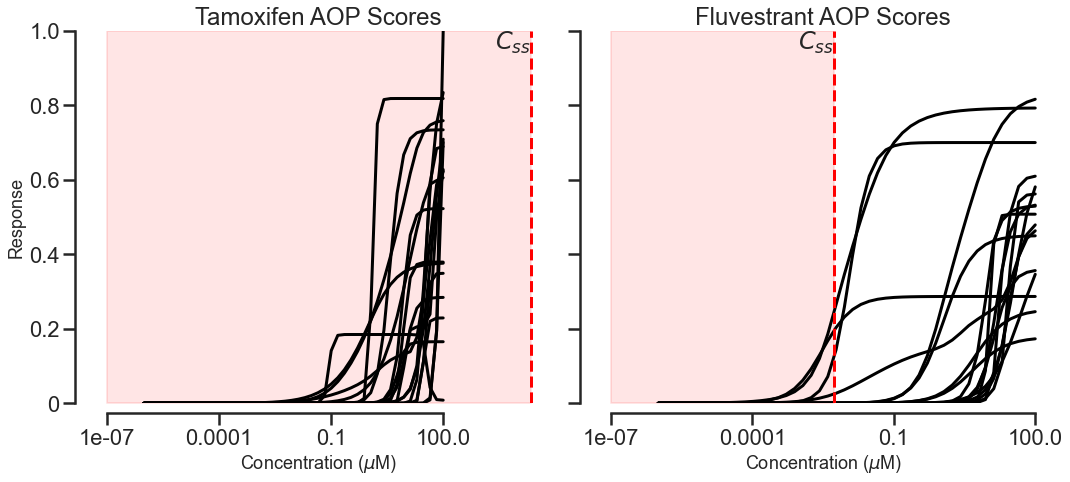

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context('poster')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharey=True)


# TAM   
axarr[0] = sns.lineplot(data=tamoxifen_aop, 
                        x="Concentration", 
                        y="Response", 
                        ax=axarr[0], 
                        legend=False, 
                        label='Tamoxifen AOP Scores',
                        hue='AOP',
                        palette=['k']*tamoxifen_aop.AOP.nunique(),
                        lw=3, 
                        ls='-')
                        
axarr[0].axvline(tam_css, color='red', ls='--', lw=3)

# FLU   
axarr[1] = sns.lineplot(data=fluvestrant_aop, 
                        x="Concentration", 
                        y="Response", 
                        ax=axarr[1], 
                        legend=False, 
                        label='Tamoxifen AOP Scores',
                        hue='AOP',
                        palette=['k']*fluvestrant_aop.AOP.nunique(),
                        lw=3, 
                        ls='-')

axarr[1].axvline(flu_css, color='red', ls='--', lw=3)


axarr[0].set(xscale="log")
axarr[1].set(xscale="log")

axarr[0].set_ylim(0, 1)
axarr[1].set_ylim(0, 1)


yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

for i in [0, 1]:
    axarr[i].set_yticks(yticks)
    axarr[i].set_yticklabels(yticks, fontsize=14)



xticks = axarr[0].get_xticks()[1:-2]


for i in [0, 1]:
    if i == 1:
        axarr[i].set_xticks(xticks)
        axarr[i].set_xticklabels(xticks, fontsize=14)
    else:
        
        axarr[i].set_xticks(list(xticks))
        axarr[i].set_xticklabels(list(xticks), fontsize=14)
    
    axarr[i].set_ylabel('Response', fontsize=18)
    axarr[i].set_xlabel('Concentration ($\mu$M)', fontsize=18)
    #axarr[i].set_xlim(0.001, 1E5)


axarr[0].set_title('Tamoxifen AOP Scores')
axarr[1].set_title('Fluvestrant AOP Scores')



axarr[0].text(tam_css, 0.95, '$C_{ss}$', ha='right')
axarr[1].text(flu_css, 0.95, '$C_{ss}$', ha='right')

axarr[0].fill_between([xticks[0], tam_css], 0, 1, color='red', alpha=0.1)
axarr[1].fill_between([xticks[0], flu_css], 0, 1, color='red', alpha=0.1)

# plt.legend(handles=[], loc=2, prop={"size":20})
plt.tight_layout()
sns.despine(offset=10, trim=True);
plt.savefig('../data/figures/tam_flu_compare.png', transparent=True)

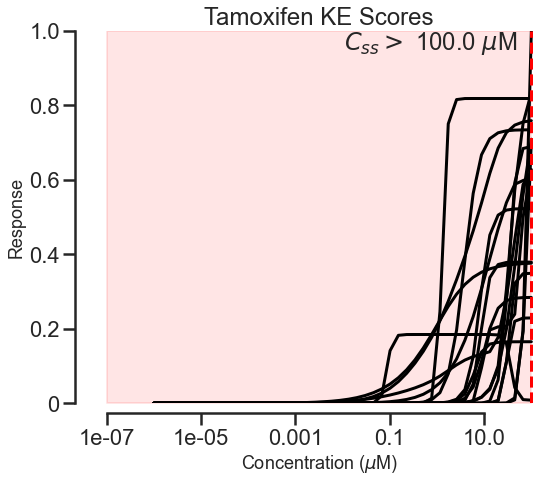

In [22]:
sns.set_style("ticks")
sns.set_context('poster')

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(8, 7), sharey=True)
css = min(tam_css, tamoxifen_aop.Concentration.max())

# TAM   
axarr = sns.lineplot(data=tamoxifen_aop, 
                        x="Concentration", 
                        y="Response", 
                        ax=axarr, 
                        legend=False, 
                        label='Tamoxifen KE Scores',
                        hue='AOP',
                        palette=['k']*tamoxifen_aop.AOP.nunique(),
                        lw=3, 
                        ls='-')
                        
axarr.axvline(css, color='red', ls='--', lw=3)




axarr.set(xscale="log")


axarr.set_ylim(0, 1)



yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]


axarr.set_yticks(yticks)
axarr.set_yticklabels(yticks, fontsize=14)



xticks = axarr.get_xticks()[1:-2]



axarr.set_xticks(xticks)
axarr.set_xticklabels(xticks, fontsize=14)

    
axarr.set_ylabel('Response', fontsize=18)
axarr.set_xlabel('Concentration ($\mu$M)', fontsize=18)
    #axarr[i].set_xlim(0.001, 1E5)


axarr.set_title('Tamoxifen KE Scores')





axarr.text(css-50, 0.95, '$C_{ss} > $' + ' ' +str(css) +' $\mu$M', ha='right')


axarr.fill_between([xticks[0], css], 0, 1, color='red', alpha=0.1)


# plt.legend(handles=[], loc=2, prop={"size":20})
plt.tight_layout()
sns.despine(offset=10, trim=True);
plt.savefig('../data/figures/tam.png', transparent=True)

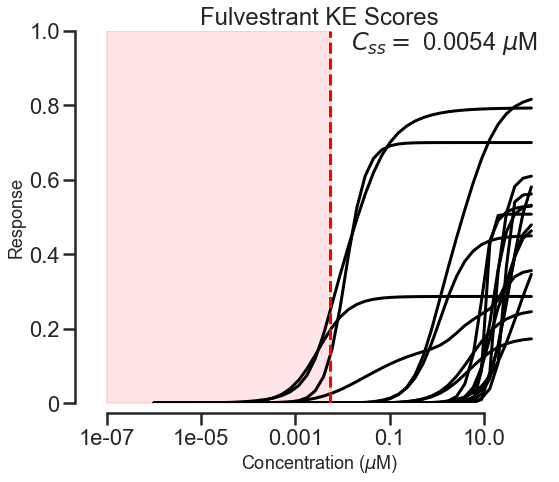

In [23]:
sns.set_style("ticks")
sns.set_context('poster')

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(8, 7), sharey=True)


# TAM   
axarr = sns.lineplot(data=fluvestrant_aop, 
                        x="Concentration", 
                        y="Response", 
                        ax=axarr, 
                        legend=False, 
                        label='Fluvestrant KE Scores',
                        hue='AOP',
                        palette=['k']*fluvestrant_aop.AOP.nunique(),
                        lw=3, 
                        ls='-')
                        
axarr.axvline(flu_css, color='red', ls='--', lw=3)




axarr.set(xscale="log")


axarr.set_ylim(0, 1)



yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]


axarr.set_yticks(yticks)
axarr.set_yticklabels(yticks, fontsize=14)



xticks = axarr.get_xticks()[1:-2]



axarr.set_xticks(xticks)
axarr.set_xticklabels(xticks, fontsize=14)

    
axarr.set_ylabel('Response', fontsize=18)
axarr.set_xlabel('Concentration ($\mu$M)', fontsize=18)
    #axarr[i].set_xlim(0.001, 1E5)


axarr.set_title('Fulvestrant KE Scores')




axarr.text(flu_css+0.01, 0.95, '$C_{ss} = $' + ' ' +str(round(flu_css, 4)) +' $\mu$M', ha='left')

axarr.fill_between([xticks[0], flu_css], 0, 1, color='red', alpha=0.1)


# plt.legend(handles=[], loc=2, prop={"size":20})
plt.tight_layout()
sns.despine(offset=10, trim=True);
plt.savefig('../data/figures/flu.png', transparent=True)